## Solar

Project Solar is an attempt to equire information about sourounding envrionment in a living space, analize it, and build predictions in order to answer:

> Determine value of artificial light to counteract its natural deficit

+ Given time of the day, provide an answer about the level of light
+ Given time of the day (and day of the week) - provide an answer if light should be on

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split

In [2]:
from sklearn.externals import joblib
df = joblib.load('data/sensing_numeric.sav')
df.columns

Index(['dot_week', 'light_level', 'light_log_mms', 'light_log_sss',
       'location_black', 'location_blue', 'location_green', 'location_orange',
       'location_purple', 'motion', 'present', 'sound_log_mms',
       'sound_log_sss', 'sun_cat', 'timestamp'],
      dtype='object')

#### Adding classification feature (predictable benchmark)

In [3]:
df['light_level'].value_counts()

0    199465
5     86441
4      6536
3      5020
2      3353
1      3351
Name: light_level, dtype: int64

#### Feature selection (including sensing)

In [4]:
y = df['light_level']
X = df[df.columns.difference(['light_level_sss','light_level','light_log_mms','light_log_sss','sound_log_mms'])]
X.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 304166 entries, (426384, 2018-05-14 00:00:00) to (730584, 2018-05-27 23:32:00)
Data columns (total 11 columns):
dot_week           304166 non-null int64
location_black     304166 non-null uint8
location_blue      304166 non-null uint8
location_green     304166 non-null uint8
location_orange    304166 non-null uint8
location_purple    304166 non-null uint8
motion             304166 non-null int64
present            304166 non-null int64
sound_log_sss      304166 non-null float64
sun_cat            304166 non-null int8
timestamp          304166 non-null int64
dtypes: float64(1), int64(4), int8(1), uint8(5)
memory usage: 21.4 MB


#### Train split

In [6]:
TRAIN_SIZE = 0.7
head = df.tail(1).index.get_level_values('id').values[0] - df.head(1).index.get_level_values('id').values[0]
train_top_id = df.head(1).index.get_level_values('id').values[0] + round(head * TRAIN_SIZE)
train = df.loc[df.index.get_level_values('id') <= train_top_id]
test = df.loc[df.index.get_level_values('id') > train_top_id]
X_train = train[X.columns]
X_test = test[X.columns]
y_train = train['light_level']
y_test = test['light_level']

#### Logistic Regression

In [7]:
from sklearn.linear_model import LogisticRegression
from helpers import print_predict_scores
from helpers import fit_predict
logReg = LogisticRegression()

In [8]:
(model, prediction) = fit_predict(X_train, y_train, logReg)

p-values:
[  5.01840968e-43   6.86089769e-06   6.01884090e-05   3.07625668e-08
   1.67211860e-01   2.04631862e-01   0.00000000e+00   0.00000000e+00
   5.83704196e-04   0.00000000e+00   5.01840968e-43]

coefficients:
[[ -2.13278622e-03  -2.02969037e-02  -1.99531097e-02   3.98884202e-03
    5.81189165e-02   1.26949397e-01  -6.41878554e-01  -4.57046539e-01
   -9.77161063e-02   4.39626639e-01  -2.13278622e-03]
 [ -1.92145907e-02  -7.02282579e-01  -6.96824624e-01  -6.94213023e-01
   -6.92177449e-01  -6.99579429e-01  -3.44481353e-04   7.01474644e-01
   -1.96485306e-02  -2.65361653e-01  -1.92145907e-02]
 [ -1.74756197e-02  -7.06138578e-01  -6.82887536e-01  -6.75155591e-01
   -6.91420335e-01  -7.35890670e-01   2.18308491e-01   5.99178076e-01
   -3.60204807e-03  -2.62247887e-01  -1.74756197e-02]
 [ -1.88070955e-02  -6.32674548e-01  -6.11011018e-01  -6.06081381e-01
   -6.25666385e-01  -6.82707487e-01   3.09680588e-01   6.46004202e-01
   -1.55213269e-02  -2.65491599e-01  -1.88070955e-02]
 [ -2.29

In [9]:
from sklearn.metrics import mean_squared_error, classification_report, precision_score, recall_score, confusion_matrix

In [10]:
print(mean_squared_error(y_train, prediction))
print(classification_report(y_train, prediction))

7.59472660837
             precision    recall  f1-score   support

          0       0.67      0.95      0.79    141035
          1       0.00      0.00      0.00      2363
          2       0.00      0.00      0.00      2360
          3       0.00      0.00      0.00      3533
          4       0.00      0.00      0.00      4574
          5       0.45      0.10      0.17     59053

avg / total       0.57      0.66      0.57    212918



/Users/radek.czarnecki/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [11]:
print('Test score r2:', logReg.score(X_test,y_test))

Test score r2: 0.656102051552


#### Parameters optimization - cross validation

In [44]:
from sklearn.model_selection import GridSearchCV, KFold

In [45]:
param_grid = [
    {'C': [10**-i for i in range(-5, 5)], 'class_weight': [None, 'balanced']}
]
grid = GridSearchCV(
    estimator=logReg,
    param_grid=param_grid,
    cv=7,
    scoring = 'neg_mean_squared_error'
)

In [46]:
grid.fit(X_train, y_train)
grid.best_estimator_

LogisticRegression(C=100000, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [47]:
(model, prediction) = fit_predict(X_train, y_train, grid.best_estimator_)

p-values:
[  5.01840968e-43   6.86089769e-06   6.01884090e-05   3.07625668e-08
   1.67211860e-01   2.04631862e-01   0.00000000e+00   0.00000000e+00
   5.83704196e-04   0.00000000e+00   5.01840968e-43]

coefficients:
[[ -2.13359150e-03  -2.02811457e-02  -1.99490591e-02   3.94279974e-03
    5.81699453e-02   1.27007970e-01  -6.42076817e-01  -4.57081124e-01
   -9.78455893e-02   4.39630671e-01  -2.13359150e-03]
 [ -1.85723895e-02  -7.06638245e-01  -7.00288095e-01  -6.89577207e-01
   -7.00440934e-01  -7.03337780e-01  -2.50696061e-04   7.03875974e-01
    3.16937919e-04  -2.64252461e-01  -1.85723895e-02]
 [ -1.68277036e-02  -7.10374390e-01  -6.86233510e-01  -6.70338704e-01
   -6.99831682e-01  -7.40038583e-01   2.19710494e-01   6.01222019e-01
    1.64824052e-02  -2.61123251e-01  -1.68277036e-02]
 [ -1.84144241e-02  -6.35318265e-01  -6.13081845e-01  -6.03004042e-01
   -6.30911653e-01  -6.85400304e-01   3.10836970e-01   6.47354387e-01
   -2.92552361e-03  -2.64803497e-01  -1.84144241e-02]
 [ -2.26

In [48]:
print(classification_report(y_train, prediction))

             precision    recall  f1-score   support

          0       0.67      0.95      0.79    141035
          1       0.00      0.00      0.00      2363
          2       0.00      0.00      0.00      2360
          3       0.00      0.00      0.00      3533
          4       0.00      0.00      0.00      4574
          5       0.45      0.10      0.17     59053

avg / total       0.57      0.66      0.57    212918



/Users/radek.czarnecki/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [49]:
print('Test score r2:', model.score(X_test,y_test))

Test score r2: 0.656102051552


#### KNeighbors

In [19]:
df.columns

Index(['dot_week', 'light_level', 'light_log_mms', 'light_log_sss',
       'location_black', 'location_blue', 'location_green', 'location_orange',
       'location_purple', 'motion', 'present', 'sound_log_mms',
       'sound_log_sss', 'sun_cat', 'timestamp'],
      dtype='object')

In [20]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
knn = KNeighborsClassifier(n_neighbors=5)

In [21]:
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [22]:
prediction5 = knn.predict(X_train)

In [23]:
print(confusion_matrix(y_train, prediction5))

[[131320    152     80    201    309   8973]
 [  1266    374     32     41     59    591]
 [  1276     59    329     63     76    557]
 [  1778     75     58    648    127    847]
 [  2184     57     59    109    964   1201]
 [ 16790    300    164    367    766  40666]]


In [24]:
print(classification_report(y_train, prediction5))

             precision    recall  f1-score   support

          0       0.85      0.93      0.89    141035
          1       0.37      0.16      0.22      2363
          2       0.46      0.14      0.21      2360
          3       0.45      0.18      0.26      3533
          4       0.42      0.21      0.28      4574
          5       0.77      0.69      0.73     59053

avg / total       0.80      0.82      0.81    212918



In [25]:
print('Train score r2:', knn.score(X_train,y_train))
print('Test score r2:', knn.score(X_test,y_test))

Train score r2: 0.818629707211
Test score r2: 0.684694459057


In [614]:
from sklearn.model_selection import cross_val_predict

In [615]:
y_pred = cross_val_predict(knn, X_train, y_train)

In [616]:
conf_mx = confusion_matrix(y_train, y_pred)
conf_mx

array([[135858,     11,     11,     11,      5,     31,     39,    130,
         14608],
       [   280,      0,      1,      0,      0,      0,      2,      6,
           183],
       [   315,      2,      0,      0,      0,      2,      2,      6,
           167],
       [   283,      1,      1,      1,      0,      1,      0,      5,
           165],
       [   279,      0,      0,      0,      1,      4,      0,      4,
           175],
       [   602,      1,      1,      1,      0,      5,      4,      7,
           328],
       [   902,      0,      1,      1,      0,      6,      4,      6,
           513],
       [  1386,      4,      3,      1,      3,     10,      4,     31,
           894],
       [ 22452,     15,      7,     13,      8,     37,     59,    180,
         29059]])

Regression models:
    - linear support regressor
    - linear vs non-linear kernel
    - random forest
    - XG Boost model

In [640]:
from sklearn.externals import joblib
filename = 'data/sensing_numeric_full.sav'
joblib.dump(df, filename)

['data/sensing_numeric_full.sav']

Keras - Python library for LSTMs modeling
- PyTorch


In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [13]:
rndm_frst = RandomForestClassifier()

In [14]:
rndm_frst.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [15]:
rndm_frst_pred = rndm_frst.predict(X_train)

In [16]:
print(classification_report(y_train, rndm_frst_pred))

             precision    recall  f1-score   support

          0       0.91      0.95      0.93    141035
          1       0.77      0.57      0.65      2363
          2       0.80      0.55      0.65      2360
          3       0.79      0.56      0.66      3533
          4       0.79      0.60      0.68      4574
          5       0.87      0.82      0.84     59053

avg / total       0.89      0.89      0.89    212918



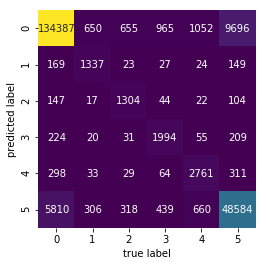

In [17]:
mat = confusion_matrix(y_train, rndm_frst_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cmap = 'viridis', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

In [18]:
print('Train score r2:', rndm_frst.score(X_train,y_train))
print('Test score r2:', rndm_frst.score(X_test,y_test))

Train score r2: 0.894085986154
Test score r2: 0.661263808522
